# Competição ML @SBS/DAA - 5ª Edição (2022/2023)

Esta competição está relacionada com o Trabalho Prático de Grupo das UCs do perfil Machine Learning: Fundamentos e Aplicações da Uminho e da UC Dados e Aprendizagem Automática, tendo, como destinatários, alunos do Mestrado em Engenharia Informática, do Mestrado em Matemática e Computação, e do Mestrado em Engenharia de Sistemas.

# Descrição da Competição
A previsão da quantidade de incidentes rodoviários é um conhecido problema de características estocásticas, não-lineares. Tem, contudo, aparecido na literatura um conjunto de modelos que demonstram um potencial assinalável neste tipo de previsões. Com isso em consideração, foi construído um dataset que contém dados referentes à quantidade e características dos incidentes rodoviários que ocorreram na cidade de Guimarães em 2021 (o dataset cobre um período que vai desde o dia 01 de Janeiro de 2021 até ao dia 31 de Dezembro do mesmo ano).

Com esta competição espera-se que os alunos desenvolvam e otimizem modelos de Machine Learning que sejam capazes de prever o número de incidentes rodoviários que irão acontecer na cidade de Guimarães a uma determinada hora.

## Imports utilizados

In [67]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Instalar as dependências necessárias

In [68]:
!pip install holidays
!pip3 install scipy
!pip3 install pydotplus
!pip3 install graphviz

### Mudar o modo que a Interactive shell imprime as variáveis

In [69]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

## Carregar os dataset de treino e de teste

In [70]:
TRAINING_DATASET_SOURCE = 'training_data.csv'
TEST_DATASET_SOURCE = 'test_data.csv'

In [71]:
train_df = pd.read_csv(TRAINING_DATASET_SOURCE)
test_df = pd.read_csv(TEST_DATASET_SOURCE)

#### Seed utilizada

In [72]:
SEED = 120

## Preparação de Dados

In [73]:
# Não tratar outliers de 'affected_roads', 'hour', 'day', 'month', 'weekday', 'weekend', 'holiday'
numeric_columns = ['avg_temperature', 'avg_atm_pressure', 'avg_humidity', 'avg_wind_speed', 'luminosity']

### Converter features categóricas para valores numéricos

In [74]:
categorical_to_numerical = {
    'luminosity': {
        'LOW_LIGHT': 0,
        'LIGHT': 1,
        'DARK': 2
    },
    'avg_rain': {
        'Sem Chuva': 0,
        'chuva fraca': 1,
        'chuva moderada': 1,
        'chuva forte': 1,
    }
}

In [75]:
from pandas import DataFrame
from sklearn.preprocessing import KBinsDiscretizer
import statistics
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox

dropped_columns = ['city_name','avg_precipitation', 'magnitude_of_delay']
holidays_in_guimaraes = pd.read_csv('national_holidays_2021.csv')

### Criar 5 bins para a feature 'hour' consoante as horas do dia e a sua quantidade de tráfego.

In [76]:
record_date = pd.DatetimeIndex(train_df['record_date'])

train_df['hour'] = record_date.hour

est = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
est.fit(train_df['hour'].to_frame())

for bin_edge in est.bin_edges_.tolist():
    print(bin_edge)

train_df['hour'] = est.transform(train_df['hour'].to_frame())

# train_df['hour'][:10]

KBinsDiscretizer(encode='ordinal', n_bins=4, strategy='uniform')

[ 0.    5.75 11.5  17.25 23.  ]


In [78]:

def month_of_the_year(month):
    pass

### Verificar se a data se refere a um feriado português.
def is_it_holiday(month, day):
    is_holiday = 0
    for date in holidays_in_guimaraes['date']:
        date_splitted = str(date).split('-')
        month_holiday = date_splitted[1]
        day_holiday = date_splitted[2]
        if str(day) == day_holiday and str(month) == month_holiday:
            is_holiday = 1
            break
    return is_holiday

# noinspection PyPep8Naming
def decision_tree_data_preparation(df: DataFrame) -> DataFrame:
    prep_df = df.drop(dropped_columns, axis=1)
    prep_df.drop_duplicates()

    ### Converter as features categoricas em numericas
    prep_df.replace(categorical_to_numerical, inplace=True)

    ### Extrair a hora e dia da semana da feature 'record_date'
    record_date = pd.DatetimeIndex(prep_df['record_date'])

    prep_df['hour'] = record_date.hour
    prep_df['day'] = record_date.day
    prep_df['month'] = record_date.month
    prep_df['weekday'] = record_date.weekday

    is_holiday = []
    i = 0
    while i < len(prep_df):
        is_holiday.append(is_it_holiday(prep_df['month'][i], prep_df['day'][i]))
        i += 1
    prep_df["is_holiday"] = is_holiday

    prep_df.drop(columns=['record_date'], inplace=True)

    train_df['affected_roads'] = train_df['affected_roads'].fillna(train_df['affected_roads'].mode().iloc[0])

    roads_already_added = []
    i = 0
    for line in prep_df['affected_roads']:
        unique_roads = set(str(line).split(','))
        for valid_road in unique_roads:
            if (valid_road != ''):
                multiple_roads = valid_road.split(' - ')
                if(len(multiple_roads) > 1):
                    if (multiple_roads[0] not in roads_already_added):
                        roads_already_added.append(multiple_roads[0])
                        prep_df[f'{multiple_roads[0]}'] = [0] * len(prep_df)
                        prep_df[f'{multiple_roads[0]}'][i] = 1     # 1 significa que essa rua foi afetada
                    else:
                        prep_df[f'{multiple_roads[0]}'][i] = 1     # 1 significa que essa rua foi afetada
                    if (multiple_roads[1] not in roads_already_added):
                        roads_already_added.append(multiple_roads[1])
                        prep_df[f'{multiple_roads[1]}'] = [0] * len(prep_df)
                        prep_df[f'{multiple_roads[1]}'][i] = 1     # 1 significa que essa rua foi afetada
                    else:
                        prep_df[f'{multiple_roads[1]}'][i] = 1     # 1 significa que essa rua foi afetada
                else:
                    if (valid_road not in roads_already_added):
                        roads_already_added.append(valid_road)
                        prep_df[f'{valid_road}'] = [0] * len(prep_df)
                        prep_df[f'{valid_road}'][i] = 1     # 1 significa que essa rua foi afetada
                    elif (valid_road in roads_already_added):
                        prep_df[f'{valid_road}'][i] = 1     # 1 significa que essa rua foi afetada
                    else:
                        pass
        i+=1
    """
    prep_df['num_affected_roads'] = num_affected_roads

    for line in test_df['affected_roads']:
        unique_roads = set(str(line).split(','))
        for valid_road in unique_roads:
            if (valid_road not in roads_already_added) & (valid_road != ''):
                roads_already_added.append(valid_road)
                prep_df[f'{valid_road}'] = [0] * len(prep_df)
                prep_df[f'{valid_road}'][i] = 1     # 1 significa que essa rua foi afetada
            elif (valid_road in roads_already_added) & (valid_road != ''):
                prep_df[f'{valid_road}'][i] = 1     # 1 significa que essa rua foi afetada
            else:
                pass
        i+=1
    """
    prep_df.drop(columns=['nan'], inplace=True)

    ### Ao analisar o resultado pós-tratamento, verificámos que a feature 'affected_roads' tinha alta correlação com 'delay_in_minutes'
    prep_df.drop(columns=['affected_roads'], inplace=True)

    ### Converter a feature 'delay_in_seconds' para 'delay_in_minutes' de modo a reduzir o intervalo de valores
    delay_in_minutes = []
    for seconds in prep_df['delay_in_seconds']:
        minutes = seconds / 60
        delay_in_minutes.append(minutes)

    prep_df.drop(columns=['delay_in_seconds'], inplace=True)
    prep_df['delay_in_minutes'] = delay_in_minutes

    # Normalizar o intervalo de valores de delay_in_minutes
    delay_2D = np.array(prep_df['delay_in_minutes']).reshape(-1, 1)
    scaler = StandardScaler()
    normalized_delay_2D = scaler.fit_transform(delay_2D)
    prep_df['delay_in_minutes'] = np.array(normalized_delay_2D).flatten()

    ### Limites superior e inferior (sem outliers) dos diagramas de caixa
    whiskers = []
    for num in numeric_columns:
        Q1 = prep_df[num].quantile(0.25)
        Q3 = prep_df[num].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        whiskers.append((num,lower,upper))

    ### Tratar os outliers das features numéricas:
    ### Substituir os valores dos outliers pela mediana
    i = 0
    for num in numeric_columns:
        median = np.median(prep_df[num])
        prep_df.loc[prep_df[num] <= whiskers[i][1], num] = median
        prep_df.loc[prep_df[num] >= whiskers[i][2], num] = median
        i = i + 1

    return prep_df

### Divisão do dataset de treino em dados de treino e de teste

In [79]:
from sklearn.model_selection import train_test_split

X = decision_tree_data_preparation(train_df)

# Separate the target variable from the input features
y = X['incidents']
X.drop(columns=['incidents'], inplace=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)


C:\Users\gonca\AppData\Local\Temp\ipykernel_8040\924569046.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep_df[f'{valid_road}'][i] = 1     # 1 significa que essa rua foi afetada
C:\Users\gonca\AppData\Local\Temp\ipykernel_8040\924569046.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep_df[f'{valid_road}'][i] = 1     # 1 significa que essa rua foi afetada
C:\Users\gonca\AppData\Local\Temp\ipykernel_8040\924569046.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

<AxesSubplot: >

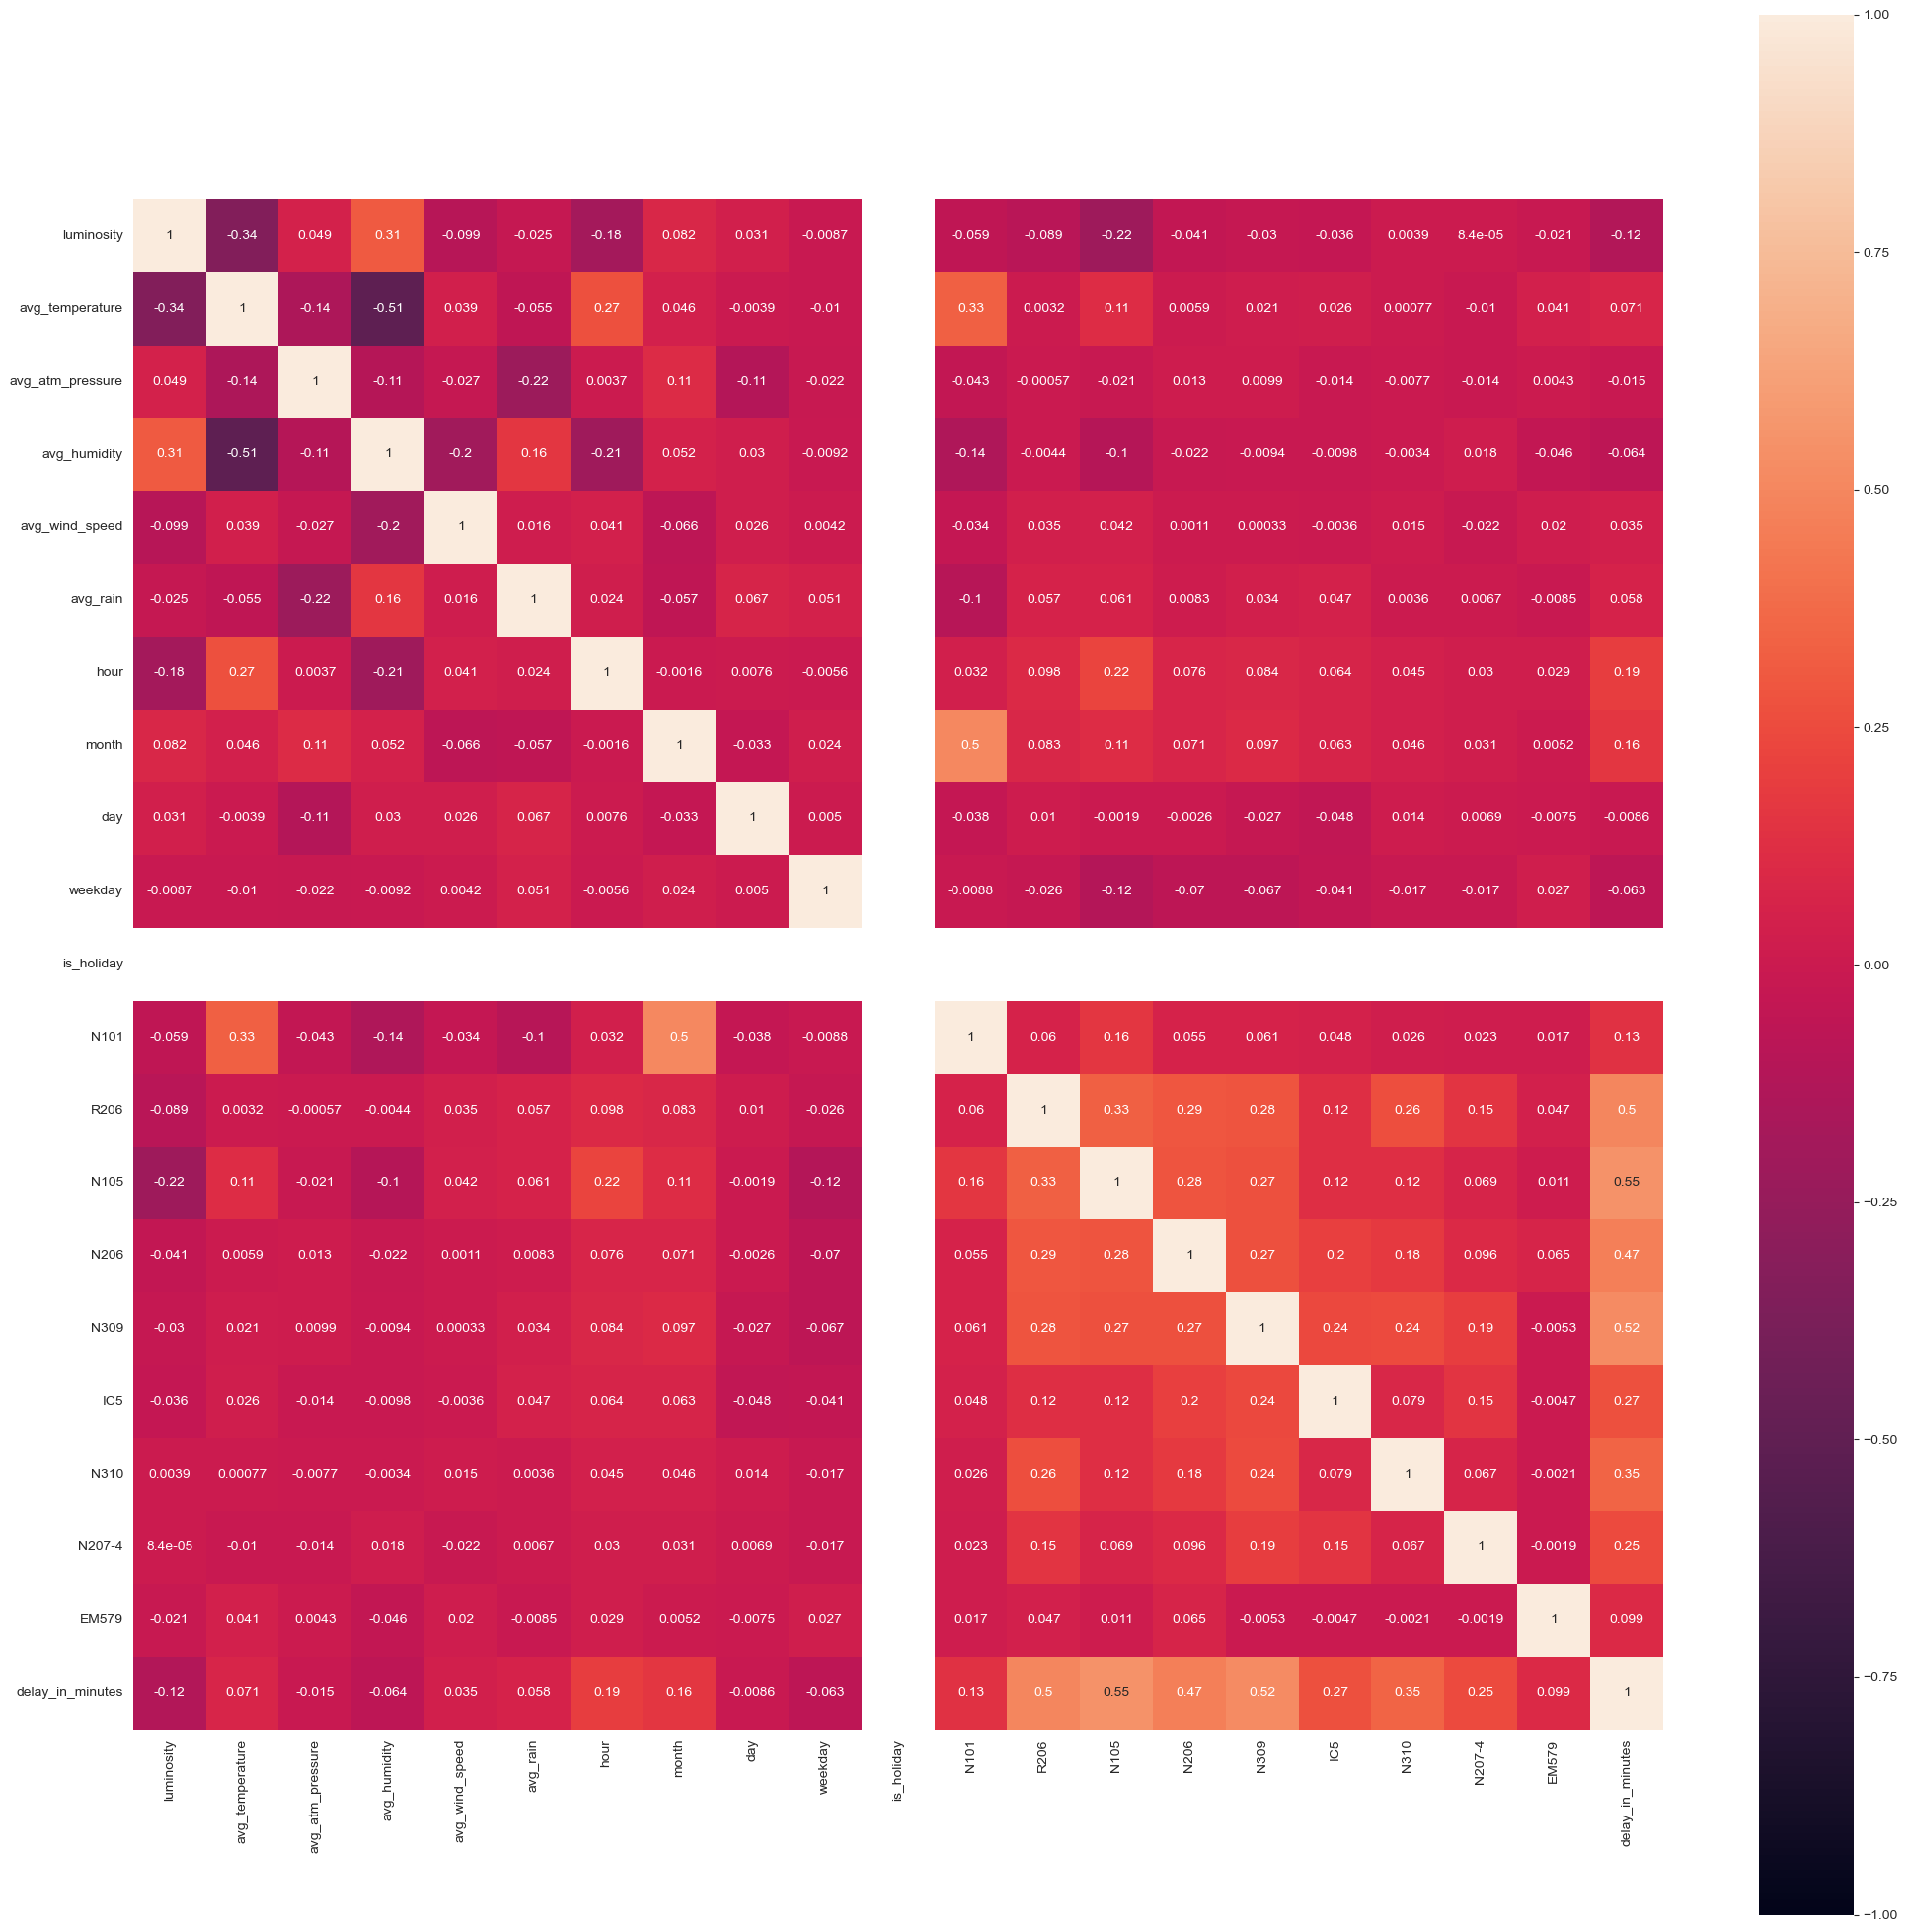

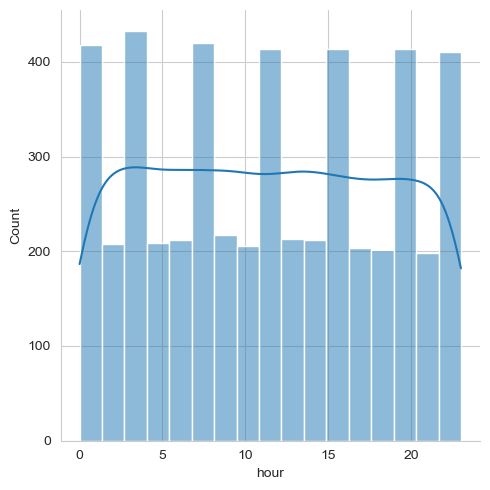

In [80]:
correlationMatrix = X.corr()
f, ax = plt.subplots(figsize=(25,25))
sns.heatmap(correlationMatrix, vmin=-1, vmax=1, square=True, annot=True)

sns.displot(X['hour'], kde=True)


### Modelo de Árvore de decisão

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create a Decision Tree model
# clf = DecisionTreeClassifier()
clf = RandomForestClassifier()
# clf = LogisticRegression(C=0.1)

"""
# Evaluate the model using 10-fold cross-validation
scores = cross_val_score(estimator=clf, X=X, y=y, cv=20)

# Print the mean and standard deviation of the scores
#print(f'Mean accuracy: {scores.mean():.3f}')
#print(f'Standard deviation: {scores.std():.3f}')

clf.fit(X_train, y_train)
"""

# Fit the model to the training data
clf.fit(X_train, y_train)

# Evaluate the model using cross-validation
scores = cross_val_score(clf, X, y, cv=100, scoring='f1_micro')

# Print the mean and standard deviation of the cross-validation scores
print("F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))


"\n# Evaluate the model using 10-fold cross-validation\nscores = cross_val_score(estimator=clf, X=X, y=y, cv=20)\n\n# Print the mean and standard deviation of the scores\n#print(f'Mean accuracy: {scores.mean():.3f}')\n#print(f'Standard deviation: {scores.std():.3f}')\n\nclf.fit(X_train, y_train)\n"

RandomForestClassifier()

F1 score: 0.90 (+/- 0.04)


#### Exportar o gráfico da árvore de decisão

In [82]:
"""
from six import StringIO 
from IPython.display import Image  
import pydotplus

prep_df = decision_tree_data_preparation(train_df)
prep_df.drop(columns=['incidents'], inplace=True)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = prep_df.columns,class_names=['0','1','2','3','4'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('incidents-decision-tree.png')
Image(graph.create_png())
"""

"\nfrom six import StringIO \nfrom IPython.display import Image  \nimport pydotplus\n\nprep_df = decision_tree_data_preparation(train_df)\nprep_df.drop(columns=['incidents'], inplace=True)\n\ndot_data = StringIO()\nexport_graphviz(clf, out_file=dot_data,  \n                filled=True, rounded=True,\n                special_characters=True,feature_names = prep_df.columns,class_names=['0','1','2','3','4'])\n\ngraph = pydotplus.graph_from_dot_data(dot_data.getvalue())  \ngraph.write_png('incidents-decision-tree.png')\nImage(graph.create_png())\n"

#### Obter as previsões

In [83]:
from sklearn.metrics import f1_score

# Make predictions on the test data
predictions = clf.predict(X_test)

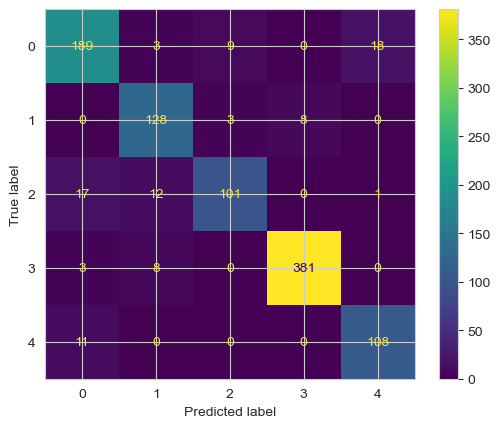

In [84]:
cm = confusion_matrix(y_test, predictions)
# TP FP
# FN TN
disp = ConfusionMatrixDisplay(cm)

disp.plot()

In [85]:
accuracy_score(y_test, predictions)
# (TP + TN) / (TP + FP + FN + TN)

precision_score(y_test, predictions, average='micro')
# TP / (TP + FP)

recall_score(y_test, predictions, average='micro')
# TP / (TP + FN)

0.907

0.907

0.907

# Reading the test dataset

In [86]:
X = decision_tree_data_preparation(test_df)


KeyError: 'month'

# Getting the predictions

In [ ]:
predictions = clf.predict(X)

predictions_df = pd.DataFrame(predictions)

predictions_df.index += 1

predictions_df.to_csv("submission.csv", header=['Incidents'], index_label='RowId')